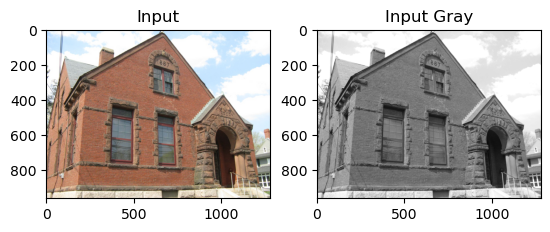

In [1]:
import cv2
import math
import numpy as np
from strokes_funct import edge_funct, strokes_funct
from matplotlib import pyplot as plt
from skimage import filters, transform
from scipy import signal

from skimage import data, img_as_float
from skimage import exposure
cv2.saliency

##input
image = cv2.imread('inputs/2--59.jpg')
scale_percent = 100 # percent of original size
height = int(image.shape[0] * scale_percent / 100)
width = int(image.shape[1] * scale_percent / 100)

dim = (width, height)

image= cv2.resize(image, dim) #redimensionar
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) ##grises

gray=gray.astype(float)
gray=filters.gaussian(gray,0.2, truncate=2)

ax1=plt.subplot(221)
ax1.imshow(image,cmap='gray')
ax1.set_title('Input')
ax2=plt.subplot(222)
ax2.imshow(gray,cmap='gray')
ax2.set_title('Input Gray')
plt.show()

## Saliency

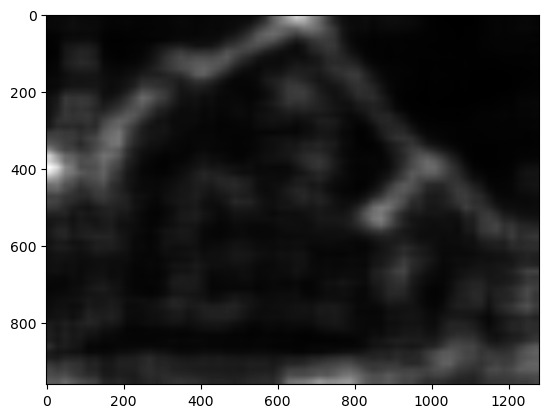

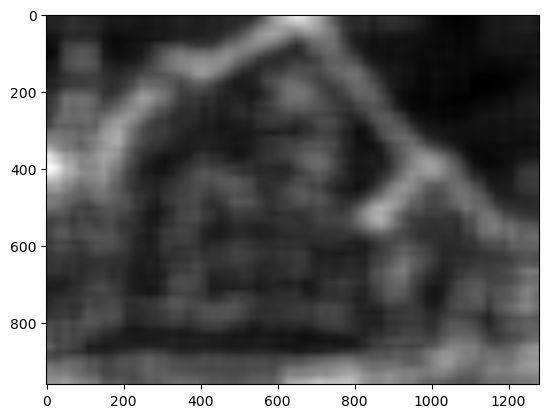

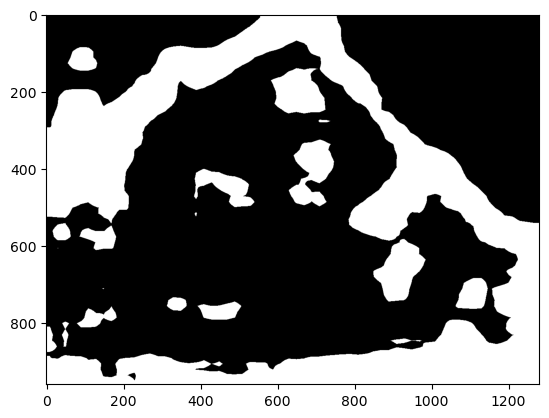

1228800


In [2]:
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
#saliencyMap = (saliencyMap * 255).astype("uint8")
salMap=np.sqrt(saliencyMap)
salMap=filters.gaussian(salMap,0.2, truncate=2)
(suc, binMap) = saliency.computeBinaryMap(salMap)
plt.imshow(saliencyMap, cmap='gray')
plt.show()
plt.imshow(salMap, cmap='gray')
plt.show()
plt.imshow(binMap, cmap='gray')
plt.show()

print(salMap.size)

# Multi res contrast pyramid

In [3]:
from get_gp import get_gp

def get_mr_img(gp, draw_mp):
    """
    Return an image from a gaussian pyramid
    """
    n = len(gp)
    r = draw_mp * (n-1)
    rin = r.astype(int)
    a = r - rin
    # rin = 3 - rin

    z = tuple(np.indices((gp[0].shape[0], gp[0].shape[1])))
    # print('a', a.shape, 'r', r.shape, 'rin', rin.shape, 'gp', gp.shape, 'z', z[0].shape, z[1].shape)
    next_m = rin+1
    next_m[next_m==n] = n-1
    # print(np.amax(rin), np.amax(r), n)
    # print('gprin', gp[(rin,) + z].shape)

    out = (1-a) * gp[(rin,) + z] + a * gp[(next_m,)+z]
    return out


(960, 1280)
(960, 1280)
(960, 1280)
(960, 1280)


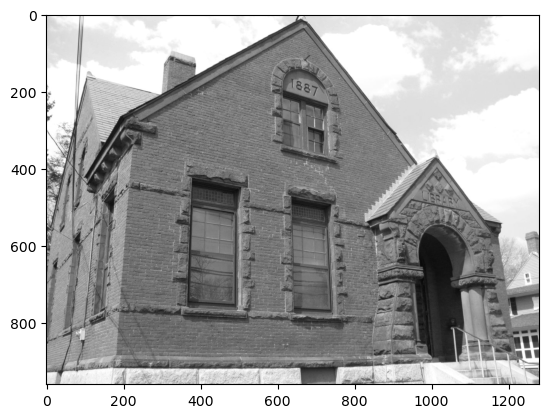

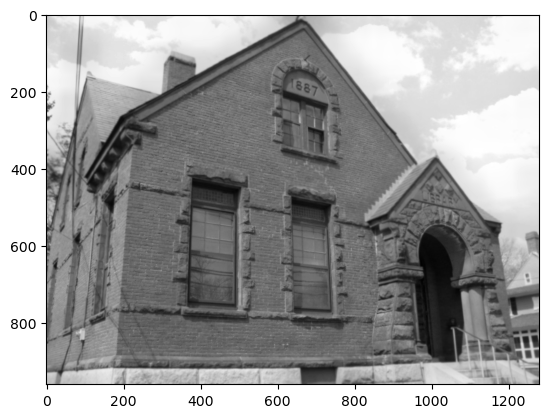

In [4]:
d_map=salMap
mc_gauss_py = [gray]
get_gp(gray, mc_gauss_py, 2, sm_size=True)

[print (i.shape) for i in mc_gauss_py]
mc_gauss_py_arr= np.array(mc_gauss_py)
mres = get_mr_img(mc_gauss_py_arr, d_map)

plt.imshow(gray, cmap='gray')
plt.show()

plt.imshow(mres, cmap='gray')
plt.show()

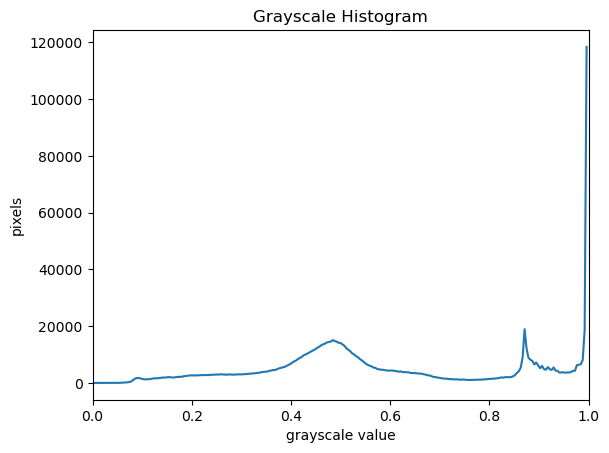

In [5]:
histogram, bin_edges = np.histogram(gray/255, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

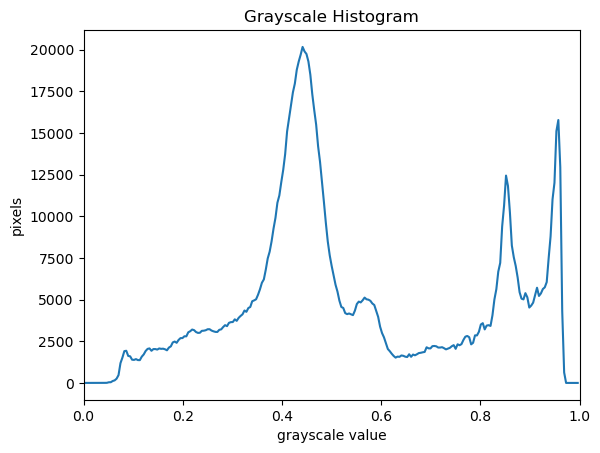

In [6]:
histogram, bin_edges = np.histogram(mres/255, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

## EDGE

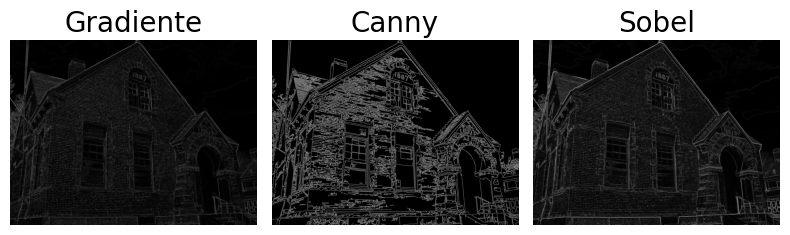

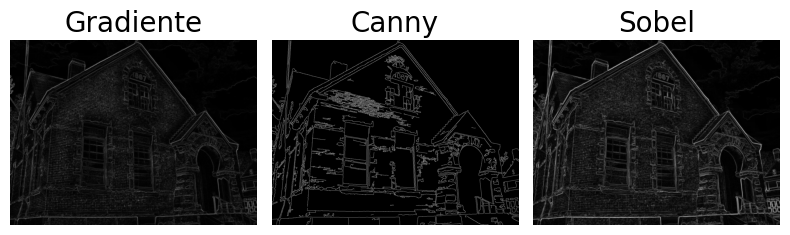

In [7]:
##Bordes
####0=gradiente, 1=canny, 2=sobel
edges=edge_funct(gray,method=0, display=True)
edgesMRES=edge_funct(mres,method=0, display=True)


## STROKE

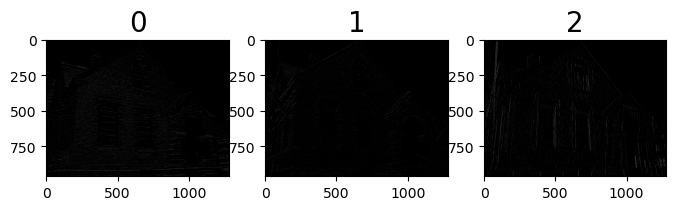

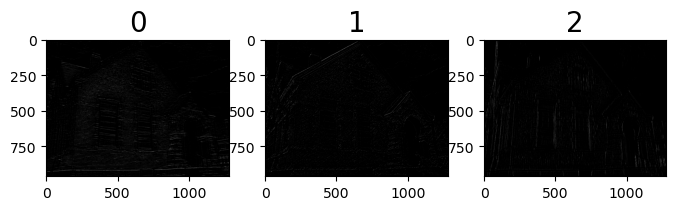

In [8]:
##STROKE 
LS= 15#int(height*(1/30))
strokes=strokes_funct(edges, lineSize=LS, display=True)
strokesMRES=strokes_funct(edgesMRES, lineSize=LS, display=True)

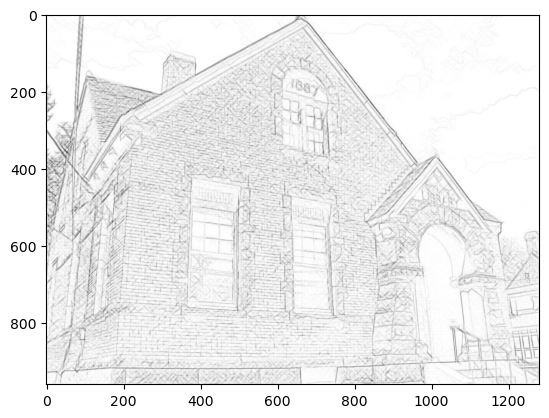

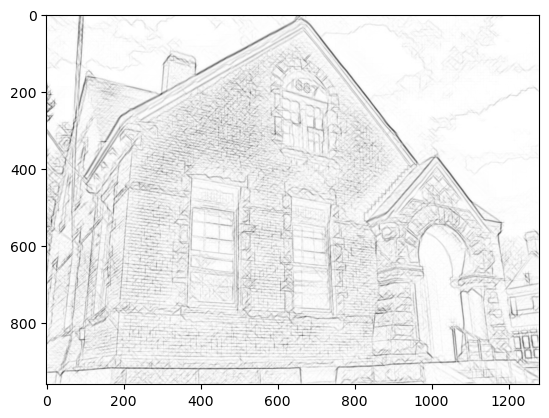

In [9]:
plt.imshow(strokes, cmap='gray')
plt.show()
plt.imshow(strokesMRES, cmap='gray')
plt.show()

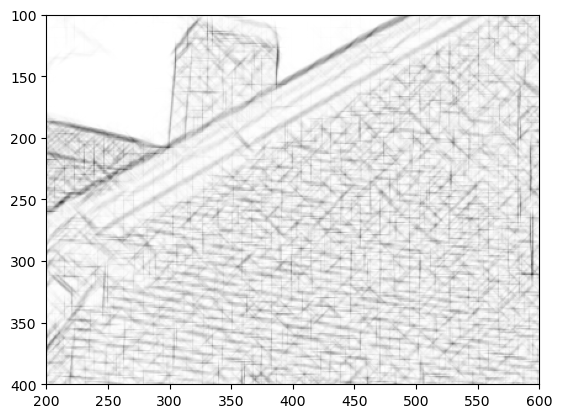

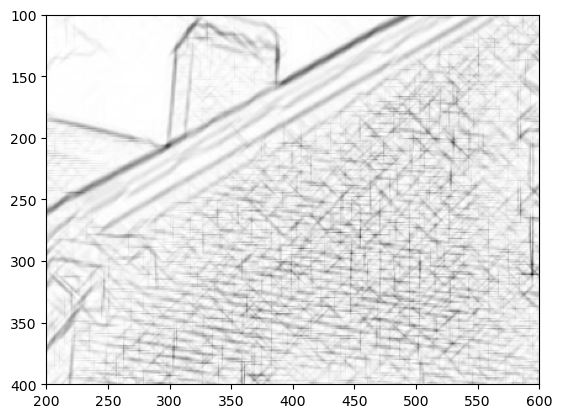

In [10]:
plt.imshow(strokes, cmap='gray') 
plt.xlim(200, 600)
plt.ylim(400,100)
plt.show()
plt.imshow(strokesMRES, cmap='gray') 
plt.xlim(200, 600)
plt.ylim(400,100)
plt.show()

In [11]:
edgesC=edge_funct(gray,method=1)
strokesC=strokes_funct(edgesC, lineSize=LS)
edgesS=edge_funct(gray,method=2)
strokesS=strokes_funct(edgesS, lineSize=LS)

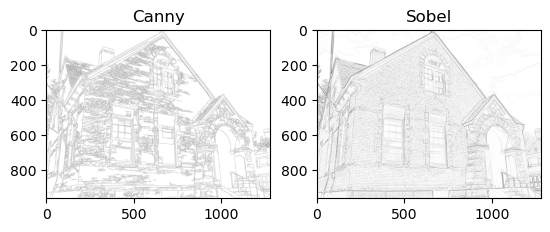

In [12]:
ax1=plt.subplot(221)
ax1.imshow(strokesC,cmap='gray')
ax1.set_title('Canny')
ax2=plt.subplot(222)
ax2.imshow(strokesS,cmap='gray')
ax2.set_title('Sobel')
plt.show()

gray=gray/255

## TONE MAP

In [13]:

##TONE MAP
#####Parametros aprendidos paper
w1, w2, w3=11,37,52   #382, 7, 11
desv_b=9
u_a=105
u_b=225
media_d=90
desv_d=11
lap_peak=255
p = np.zeros(256)
Z=0
for i in range(256):
    if i <= lap_peak:
        p1 = w1 * (1 / desv_b) * np.exp(-(255 - i) / desv_b)
    else:
        p1=0

    if (u_a <= i <= u_b):
        p2 = w2* 1 / (u_b - u_a)
    else:
        p2 = 0

    p3 = w3* (1/np.sqrt(2*math.pi*desv_d))*(np.exp(-(i-media_d)**2/(2*desv_d**2)))*0.01
    p[i] = p1 + p2 + p3
    Z=Z+p[i]

p=p/Z

## HISTOGRAM MATCHING

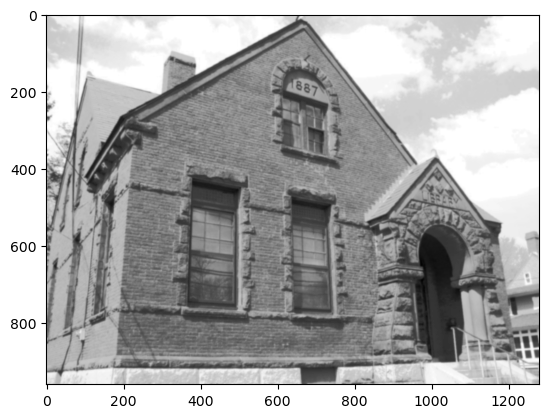

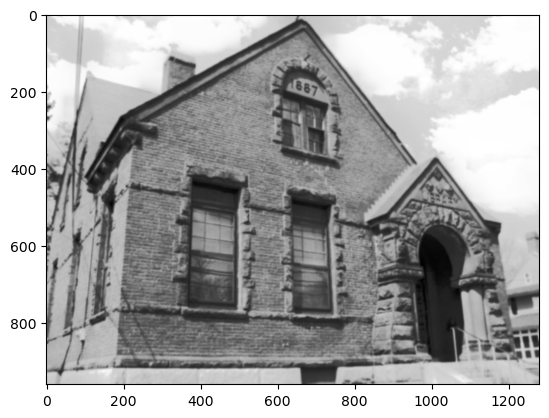

In [14]:
from hist_match import hist_match
mres=mres/255
P = np.cumsum(p)
#Equalize
# histograma original:
h = exposure.histogram(gray, nbins=256)
# CDF :
H = np.cumsum(h / np.sum(h))

# Histogram matching:
matched = np.zeros_like(p)
for v in range(256):
    # find the closest value:
    dist = np.abs(P - H[v])
    argmin_dist = np.argmin(dist)##indice del  minimo
    matched[v] = argmin_dist
matched= matched / 256

J = matched[(255 *gray).astype(int)]
J_sal=matched[(255 * (1-salMap)* gray).astype(int)]
# smooth:
J_b = filters.gaussian(J, sigma=np.sqrt(2))


J=hist_match(gray,p)
JMRES=hist_match(mres,p)

plt.imshow(J, cmap='gray')
plt.show()
plt.imshow(JMRES, cmap='gray')
plt.show()

#multi = True if P.shape[-1] > 1 else False
#matched = exposure.match_histograms(gray, p)

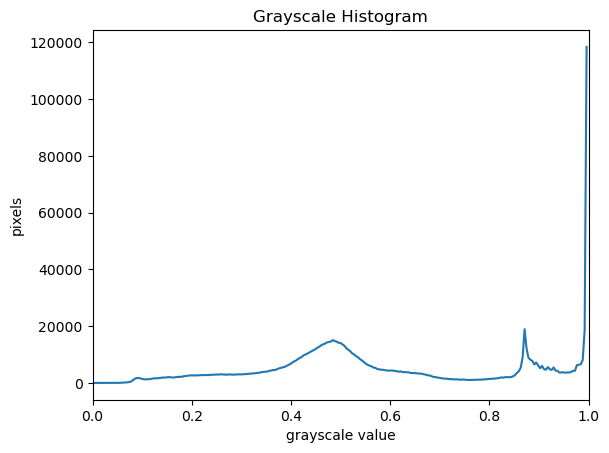

In [15]:
histogram, bin_edges = np.histogram(gray, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()


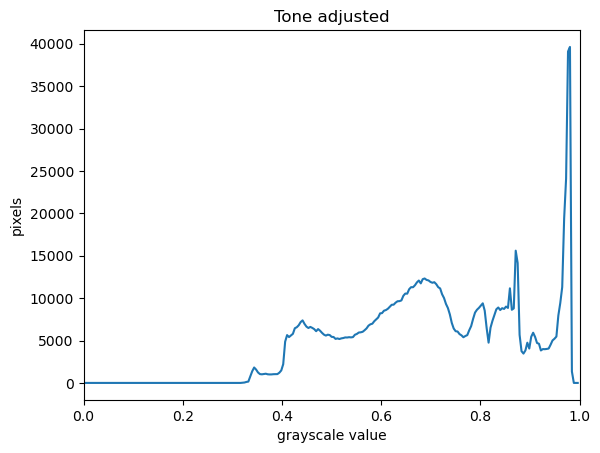

In [16]:
histogram, bin_edges = np.histogram(JMRES, bins=256, range=(0, 1))
plt.figure()
plt.title("Tone adjusted")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()


## PENCIL RENDERING

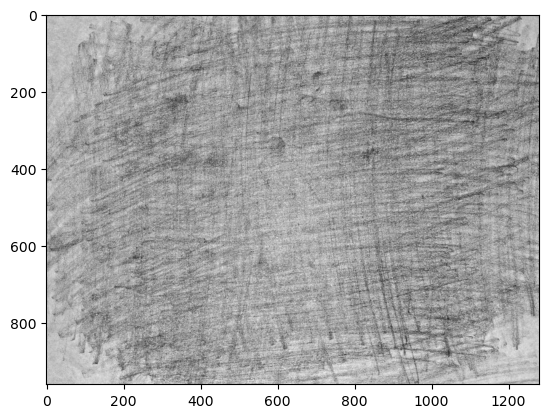

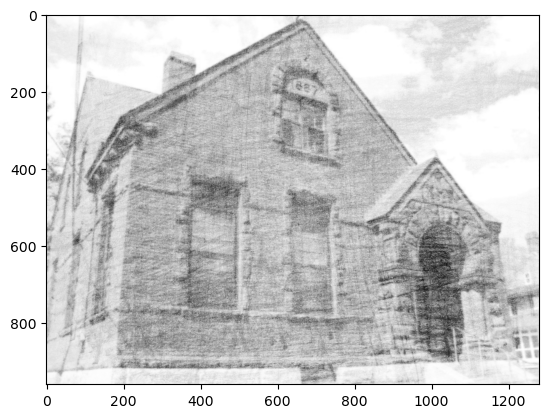

In [17]:
from scipy import  sparse

H= cv2.imread('pencils/pencil0.jpg')
H=cv2.cvtColor(H, cv2.COLOR_BGR2GRAY)*(1/255.0)

#Lambda
l = 0.2
# Adjust the input to correspond
H_res = cv2.resize(H, dim)

plt.imshow(H_res, cmap='gray')
plt.show()

H_f=H_res.flatten()
logH = np.log(H_f)

#print('H_f=\n ', H_f)    
#print('logH=\n ', logH)    
J_f= J.flatten()
logJ = np.log(J_f)
    
# In order to use Conjugate Gradient method we need to prepare some sparse matrices:
#print('ravel=\n ', logH.ravel())
logH_sparse = sparse.spdiags(logH, 0, height*width, height*width) # 0 - from main diagonal
#print('logHarr=\n',logH_sparse.toarray())

e = np.ones((height * width, 1))
#print('e=\n',e)

ee = np.concatenate((-e,e), axis=1)
#print('ee=\n',ee)

diags_x = [0, height*width]
#print('diags_x=\n',diags_x )
diags_y = [0, 1]
#print('diags_y=\n',diags_y )


ddx = sparse.spdiags(e.T, 0, height*width, height*width)
#print('ddxarr=\n',ddx.toarray() )

dddx=sparse.identity(height*width)
#print('dddxarr=\n',dddx.toarray() )

dx = sparse.spdiags(ee.T, diags_x, height*width, height*width)
#print('dx=\n',dx )
#print('dx_arr=\n',dx.toarray())
dy = sparse.spdiags(ee.T, diags_y, height*width, height*width)
#print('dy=\n',dy )
#print('dy_arr=\n',dy.toarray())
    
# Compute matrix X and b: (to solve Ax = b)
d1=dx @ dx.T
d2=dy @ dy.T
d3=logH_sparse.T @ logH_sparse

#print('d1=\n',d1 )
#print('d1arr=\n',d1.toarray() )
#print('d2=\n',d2 )
#print('d2array=\n',d2.toarray() )
#print('d3=\n',d3 )
#print('d3array=\n',d1.toarray() + d2.toarray() )

A =  l*((dx @ dx.T) + (dy @ dy.T)) + logH_sparse.T @ logH_sparse
#print('A=\n', A)
#print('Aarr =\n', A.toarray())
b = logH_sparse.T @ logJ
#print('b=\n',b )
    
# Conjugate Gradient
beta = sparse.linalg.cg(A, b, tol=1e-6, maxiter=60)
    
# Adjust the result
beta_reshaped = np.reshape(beta[0], (height, width))
    
# The final pencil texture map T
T = np.power(H_res, beta_reshaped)
 
plt.imshow(T, cmap='gray')
plt.show()

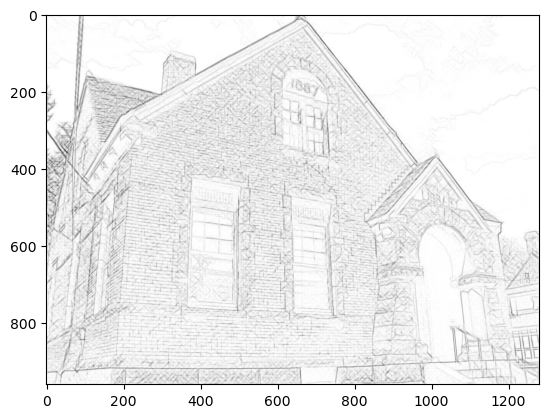

In [18]:
F=np.multiply(T,strokes)

plt.imshow(F, cmap='gray')
plt.show()
